# Time Series Analysis and Forecasting Using ARMAX

classic time series analysis tool:
- trend analysis (time-dependent)
- seasonal analysis (time-dependent)
- cyclical analysis (series-dependent)
- irregular analysis (random)

some tests
- stationary tests
    - ADF 
    - KPSS
- c 

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

sns.set_style('darkgrid')

data_file = './data/model_ready.parquet'
df = pd.read_parquet(data_file, "pyarrow")

# sort index
df = df.sort_index()
# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')

# separte names for inspection
columns = df.columns
load_names = []
wind_names = []
dewpoint_names = []
target_names = []
for col in columns:
    if 'mtlf' in col:
        load_names.append(col)
    if 'ws' in col:
        wind_names.append(col)
    if 'td' in col:
        dewpoint_names.append(col)
    if 'da_energy' in col:
        target_names.append(col)


In [56]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta(days=365) / pd.Timedelta('1H')
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104, 365])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
            "Daily (365)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

## Stationary Test
Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [57]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

<Figure size 640x480 with 0 Axes>

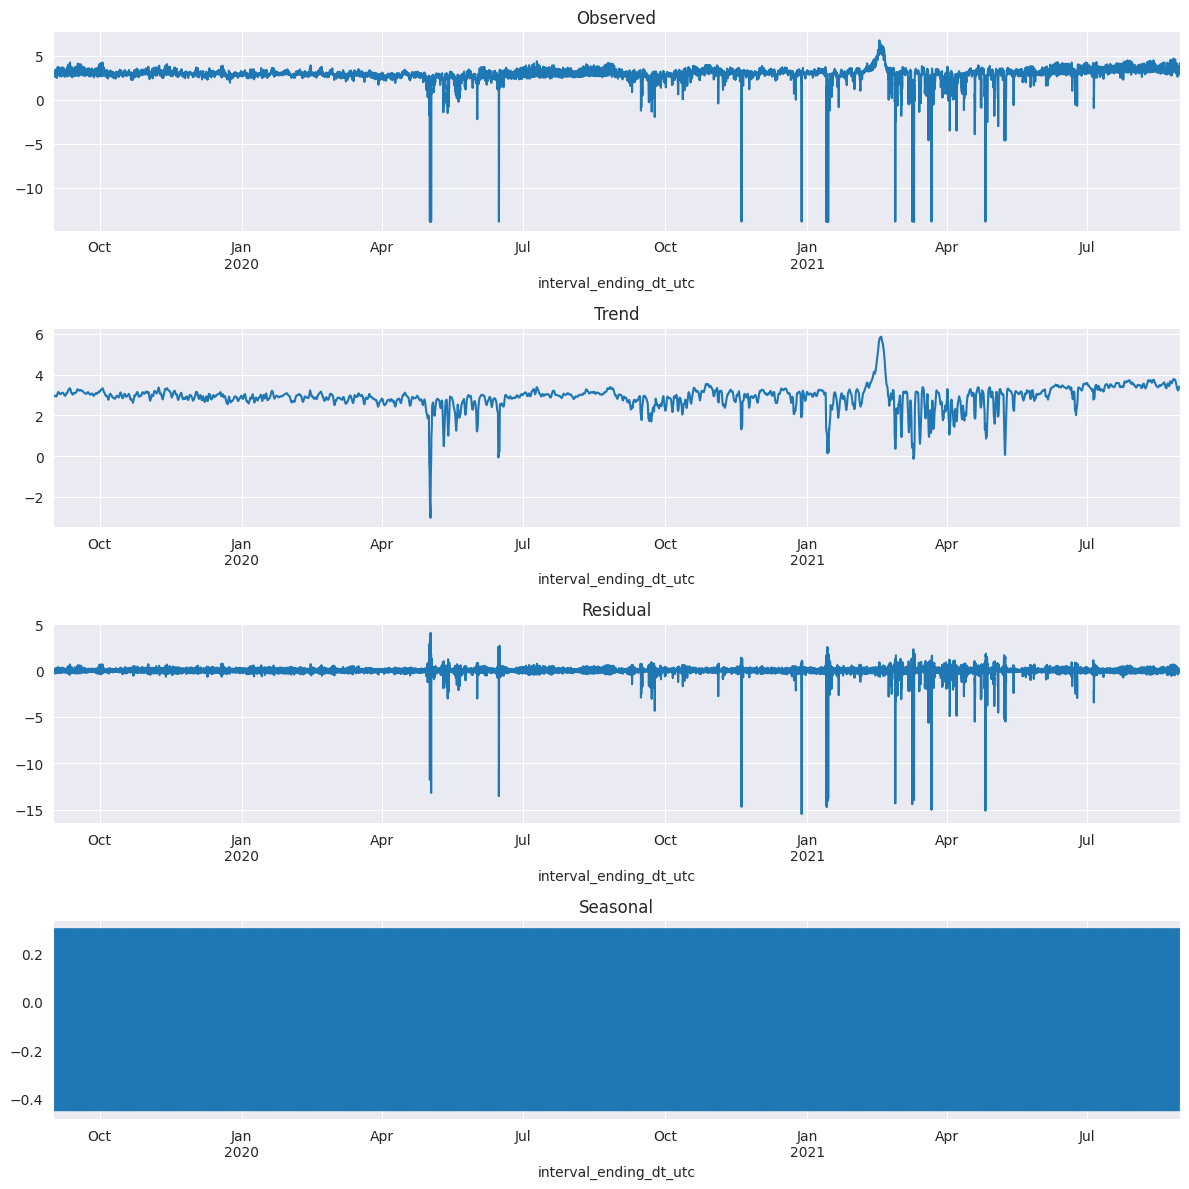

<Figure size 640x480 with 0 Axes>

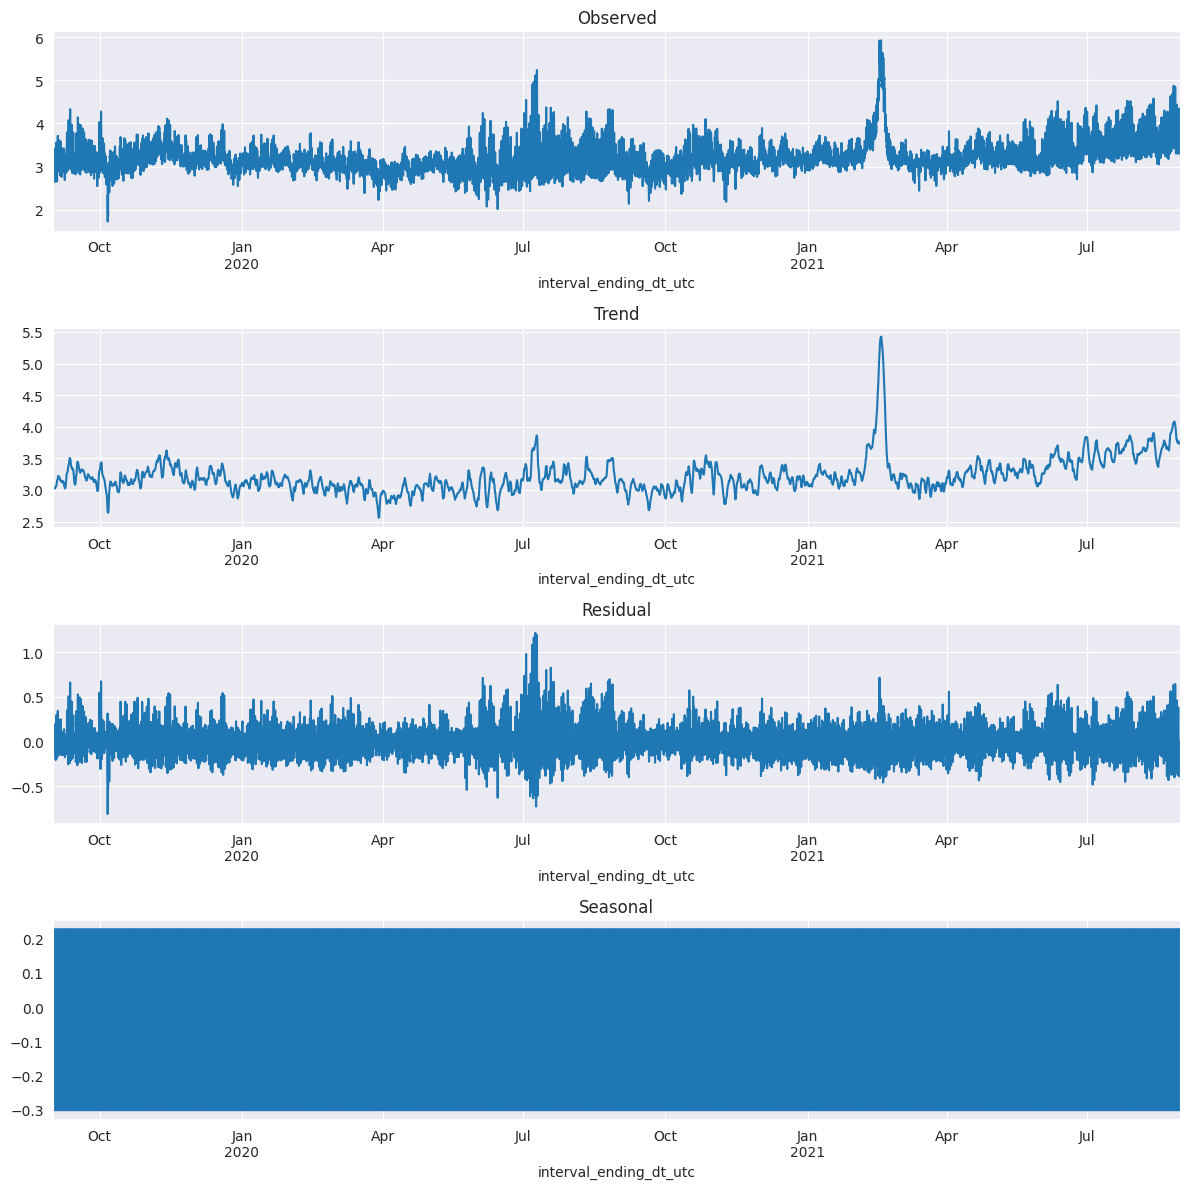

<Figure size 640x480 with 0 Axes>

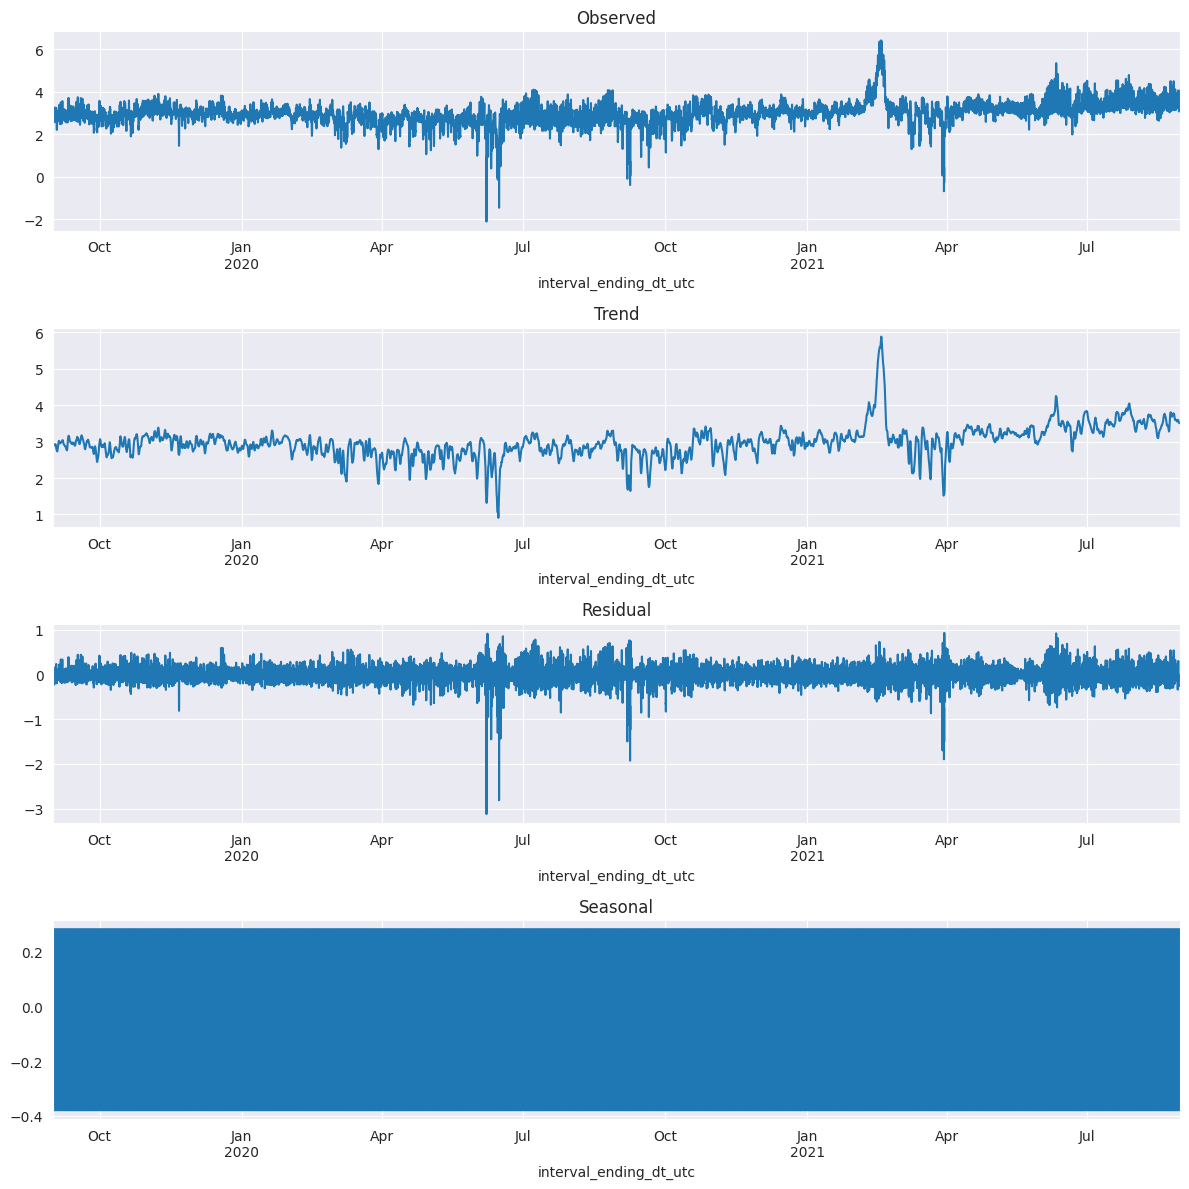

In [58]:
# Decompose the log electricity price time-series
for i, target in enumerate(target_names):
    res = sm.tsa.seasonal_decompose(np.log(df[target].abs()+1e-06), model='additive')
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

ADF test determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

If the test statistics is smaller than the critical value, we can reject the null hypothesis in favor of the alternative hypothesis.


In [59]:
for target in target_names:
    y = df[target]
    adftest = adf_test(y)


Results of Dickey-Fuller Test:
Test Statistic                -9.442901e+00
p-value                        4.841013e-16
#Lags Used                     4.300000e+01
Number of Observations Used    1.745300e+04
Critical Value (1%)           -3.430725e+00
Critical Value (5%)           -2.861706e+00
Critical Value (10%)          -2.566858e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.099454e+01
p-value                        6.924249e-20
#Lags Used                     4.300000e+01
Number of Observations Used    1.745300e+04
Critical Value (1%)           -3.430725e+00
Critical Value (5%)           -2.861706e+00
Critical Value (10%)          -2.566858e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.517134e+00
p-value                        3.135187e-16
#Lags Used                     4.400000e+01
Number of Observations Used    1.745200e+04
Critical Value (1%)           -3.430725e+00
Critical Value (5%)           -2.861706e+

The ADF statistic for all three targets are around -9.5, which is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).

If the test statistics is smaller than the critical value, we can reject the null hypothesis in favor of the alternative hypothesis.

In [60]:
for target in target_names:
    y = df[target]
    kpsstest = kpss_test(y)

Results of KPSS Test:
Test Statistic            0.942328
p-value                   0.010000
Lags Used                74.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test:
Test Statistic            2.494684
p-value                   0.010000
Lags Used                72.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test:
Test Statistic            2.437902
p-value                   0.010000
Lags Used                74.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_82724/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/tmp/ipykernel_82724/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/tmp/ipykernel_82724/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


KPSS statistics is greater than the critical value at 1% (0.739) and thus **we fail to reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is a root-unit in the time series and thus, that it is not stationary.



In summary, KPSS indicates a non-stationary series (i.e. there is a unit root) whereas ADF indicates a stationary series. This is a contradiction. The reason for this contradiction is that the KPSS test has low power in the presence of a trend. In other words, when the series is trend stationary, the KPSS test incorrectly fails to reject the null hypothesis about 33% of the time. Thus, we can conclude that the series is trend stationary.

To remove the trend, we can take the first difference of the series and then apply the ADF test again. 


<Axes: xlabel='interval_ending_dt_utc'>

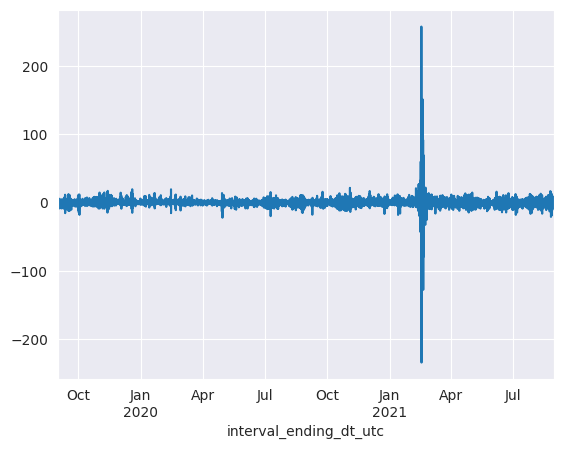

In [61]:
df_cp = df.copy()
target = target_names[0]
df_cp['diff'] = df_cp[target] - df_cp[target].shift(1)

df_cp['diff'].dropna().plot()

<Axes: xlabel='interval_ending_dt_utc'>

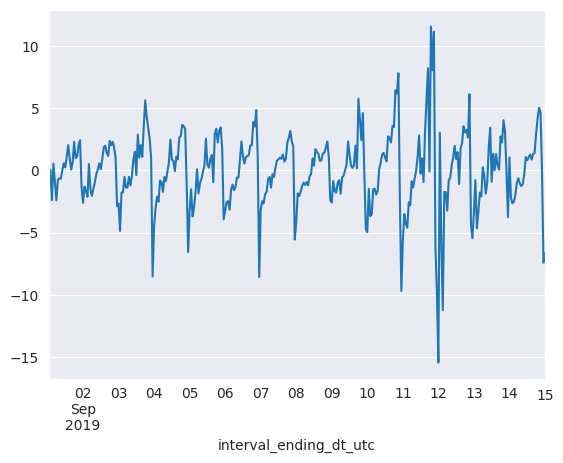

In [62]:
df_cp['diff'].dropna()[:14*24].plot()

<Axes: xlabel='interval_ending_dt_utc'>

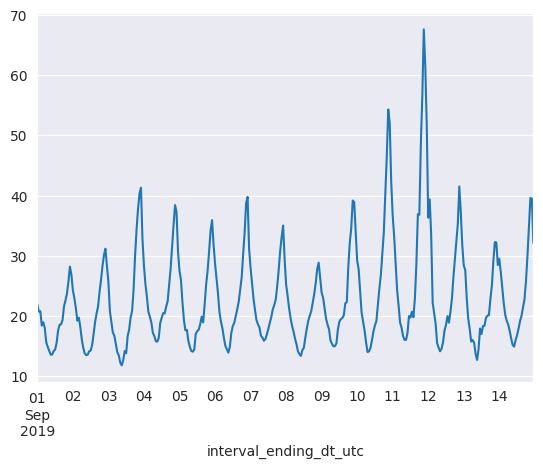

In [63]:
df_cp[target][:14*24].plot()

In [64]:
adf_test(df_cp['diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -19.776462
p-value                            0.000000
#Lags Used                        41.000000
Number of Observations Used    17454.000000
Critical Value (1%)               -3.430725
Critical Value (5%)               -2.861706
Critical Value (10%)              -2.566858
dtype: float64


The ADF test shows that the statistics is smaller than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

In [65]:
kpss_test(df_cp['diff'].dropna())

Results of KPSS Test:
Test Statistic             0.02051
p-value                    0.10000
Lags Used                584.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


/tmp/ipykernel_82724/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Now the KPSS test shows that the test statistics is smaller than the critical value at 1% (0.739) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is stationary.

## Trend

### Chect trend with moving average

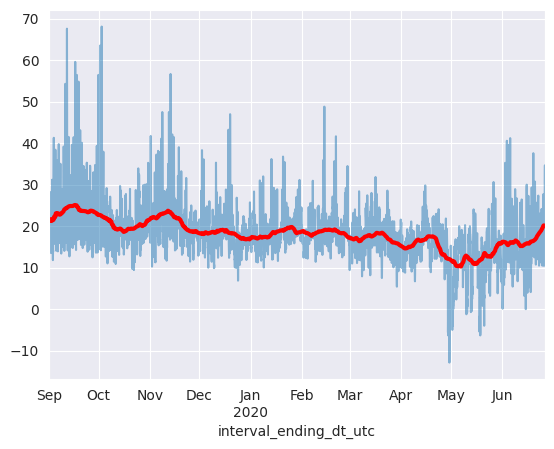

In [66]:
target = target_names[0]

## make a moving average plot
trend = df[target].rolling(
    window = 24*14,
    center = True, 
    min_periods = 6).mean()
ax = df[target][:24*300].plot(alpha=0.5)
ax = trend[:24*300].plot(ax=ax, linewidth=3, color='r')

Basically we can see that the moving average is not constant over time, so we can again conclude that there is a trend in the series.

The trending shape after moving average is not easy to see. We may need high-order nonlinear function to approximate.


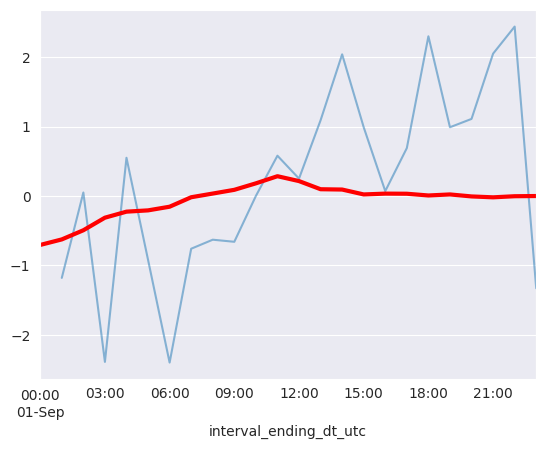

In [67]:
## make a moving average plot
trend = df_cp['diff'].rolling(
    window = 24,
    center = True, 
    min_periods = 6).mean()
ax = df_cp['diff'][:1*24].plot(alpha=0.5)
ax = trend[:1*24].plot(ax=ax, linewidth=3, color='r')

we seee that the moving-average trend after first order differencing is almost constant, so we can conclude that the trend has been removed after using the first-order differencing.

This also confirm the KPSS/ADF test results.

Therefore, we will simply use the first-order differencing to remove the trend.


## Seanality

The seasonality in the target is very obvious. Basically, we can see the target has a yearly and weekly pattern. 

In [68]:
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
target = target_names[0]
#target = 'diff'
X_original = df.drop(target_names, axis=1)
y = df[target].shift(-1) # shift the target by 1 hour as when predicting the next hour, we can only use the data up to the previous hour

# drop the last row as it has no target
Xy = pd.concat([X_original, y], axis=1).dropna()
X_original = Xy.drop(target, axis=1)
y = Xy[target]

# split train and test
n_train = int(0.85*len(X_original))
n_test = len(X_original) - n_train
X_original_train = X_original[:n_train]
y_train = y[:n_train]
X_original_test = X_original[n_train:]
y_test = y[n_train:]


base model prediction metrics: mae: 3.1278971428571425, mse: 16.883284761904765, r2: 0.9199718470088212


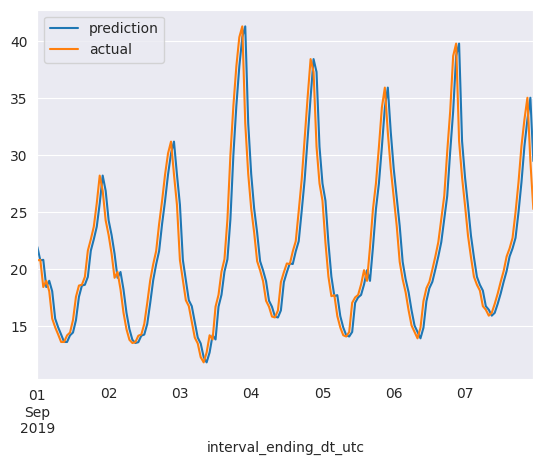

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# base model: simply use previous value as the predictions 
y_pred_base = df[target][:-1] # do need the last one
ax = y_pred_base[:24*7].plot(label='prediction')
ax = y[:24*7].plot(ax=ax, label='actual')
ax.legend()

mae_base_test = mean_absolute_error(y[n_train:], y_pred_base[n_train:])
mse_base_test = mean_squared_error(y[n_train:], y_pred_base[n_train:])
r2_base_test = r2_score(y[n_train:], y_pred_base[n_train:]) 
print(f"base model prediction metrics: mae: {mae_base_test}, mse: {mse_base_test}, r2: {r2_base_test}")

/home/yyf/miniconda3/envs/tts-tf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.817e+06, tolerance: 1.726e+03
  model = cd_fast.enet_coordinate_descent(


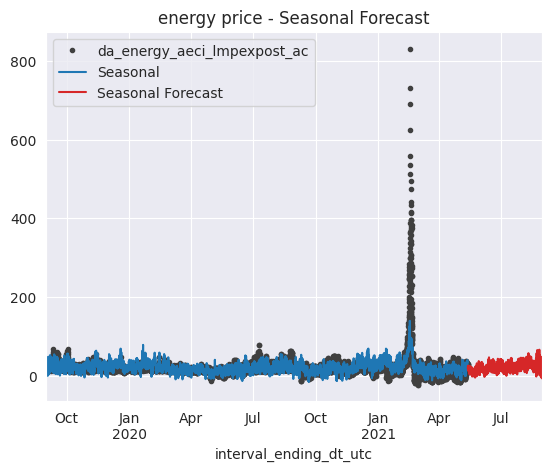

In [70]:

fourier = CalendarFourier(freq="Y", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=y_train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=0,                     # trend (order 1 means linear)
    seasonal=True,               # daily seasonality (indicators)
    additional_terms=[],         # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_dp_train = dp.in_sample()  # create features for dates in tunnel.index

# concatenate original features with deterministic features
X_train = pd.concat([X_original_train, X_dp_train], axis=1)

model = LinearRegression(fit_intercept=False)
model = Lasso(fit_intercept=False, alpha=0.1)
_ = model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=y_train.index)

X_dp_test = dp.out_of_sample(steps=n_test)
X_test = pd.concat([X_original_test, X_dp_test], axis=1)
y_fore = pd.Series(model.predict(X_test), index=X_test.index)

ax = y_train.plot(color='0.25', style='.', title="energy price - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

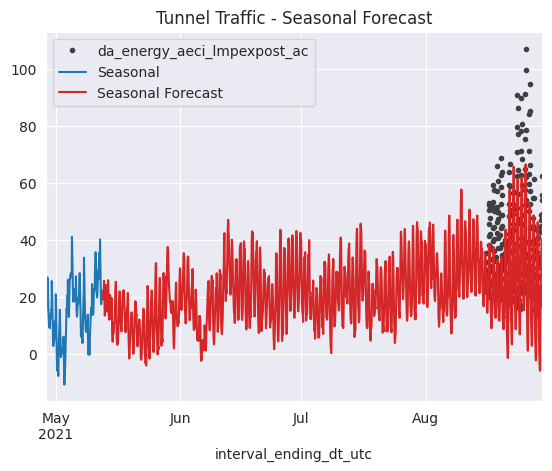

In [71]:
ax = y[-24*14:].plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred[-24*14:].plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [72]:
# get some performance metrics

mae_train = mean_absolute_error(y_train, y_pred)
mse_train = mean_squared_error(y_train, y_pred)
r2_train = r2_score(y_train, y_pred)

mae_test = mean_absolute_error(y_test, y_fore)
mse_test = mean_squared_error(y_test, y_fore)
r2_test = r2_score(y_test, y_fore)

print('training metrics: mae: {}, mse: {}, r2: {}'.format(mae_train, mse_train, r2_train))
print('testing metrics: mae: {}, mse: {}, r2: {}'.format(mae_test, mse_test, r2_test))

training metrics: mae: 9.782302396403683, mse: 502.2256055317743, r2: 0.31018358457579454
testing metrics: mae: 10.562809279499524, mse: 170.66901299783288, r2: 0.19101489575876085


In [73]:
model.coef_

array([ 1.32818677e-03, -4.68804926e-04,  4.63801797e-03, -8.36092480e-04,
       -6.42363104e-01, -5.80256005e-01, -6.52168320e-01, -2.91636997e-01,
        2.35555928e-01,  0.00000000e+00,  7.89257692e-01, -7.61087743e-01,
       -8.02390138e-01,  6.84055428e-01, -8.11353597e-01,  5.07200918e-01,
       -8.69607098e-01,  0.00000000e+00,  3.29091888e-01, -8.10384706e-01,
       -1.27130141e+00,  1.06262845e+00, -2.85769990e+00,  1.05525332e+00,
        6.39364700e-02, -0.00000000e+00, -8.69812376e-01,  2.26761823e+00,
        2.69840514e-01, -1.51571211e-01, -3.16073904e-02,  5.43151315e-02,
        7.93712175e-02,  1.18447111e+00, -1.52495267e-01,  8.10686087e-02,
       -1.94101334e+00,  0.00000000e+00, -2.29689895e+01, -8.20137376e-01,
       -3.26114449e+00, -4.70133646e+00, -4.07334891e+00, -2.04203981e+00,
       -3.61714542e-01, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  2.17612001e-01,  1.41244074e+00,  0.00000000e+00,
        0.00000000e+00,  

Text(0.5, 1.0, 'Deseasonalized')

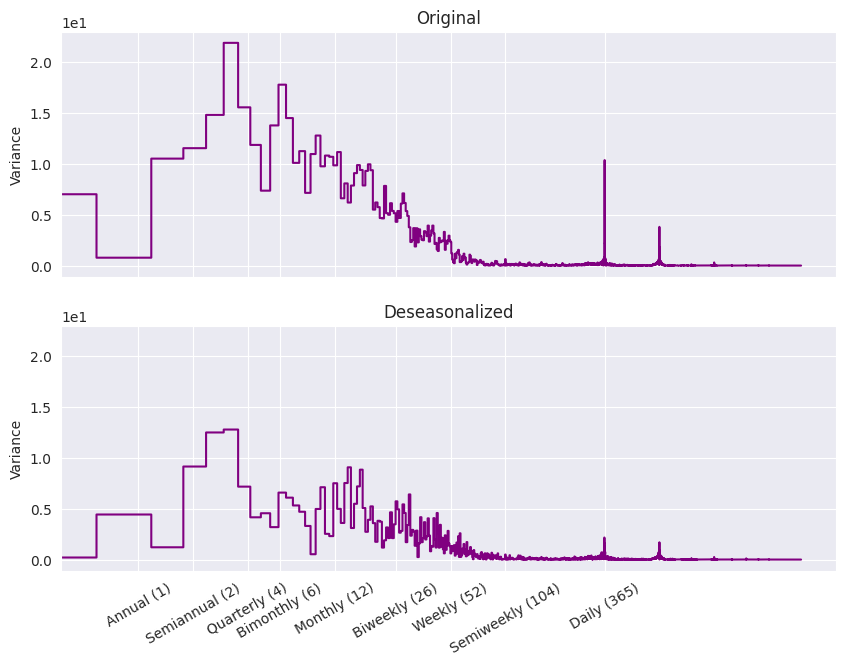

In [74]:
# check the deseaonalized residuals
y_deseason = y_train - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_train, ax=ax1)
ax1.set_title("Original")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized")


## Cycles

### Lags

With partial autocorrelation function, we can see that lag 1, 2, 5, 9 have significant correlation with the target.



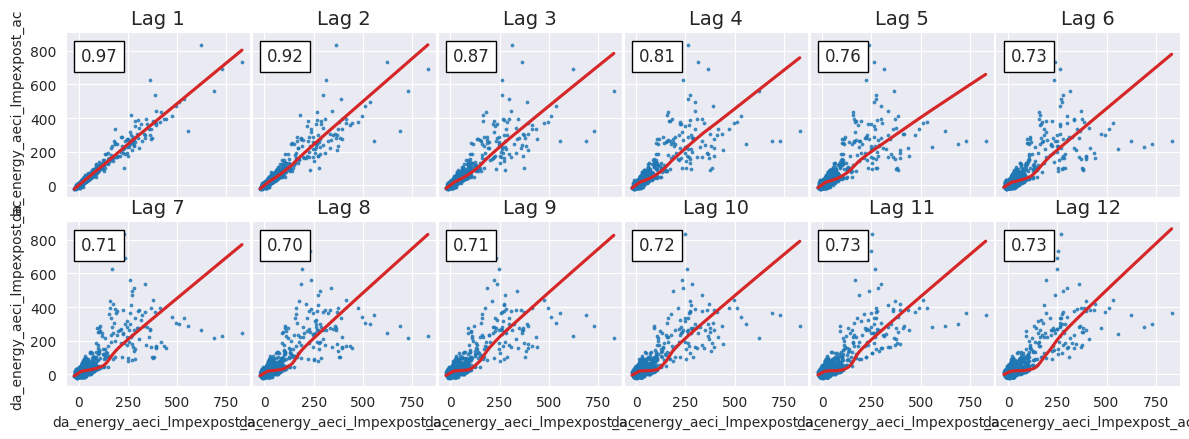

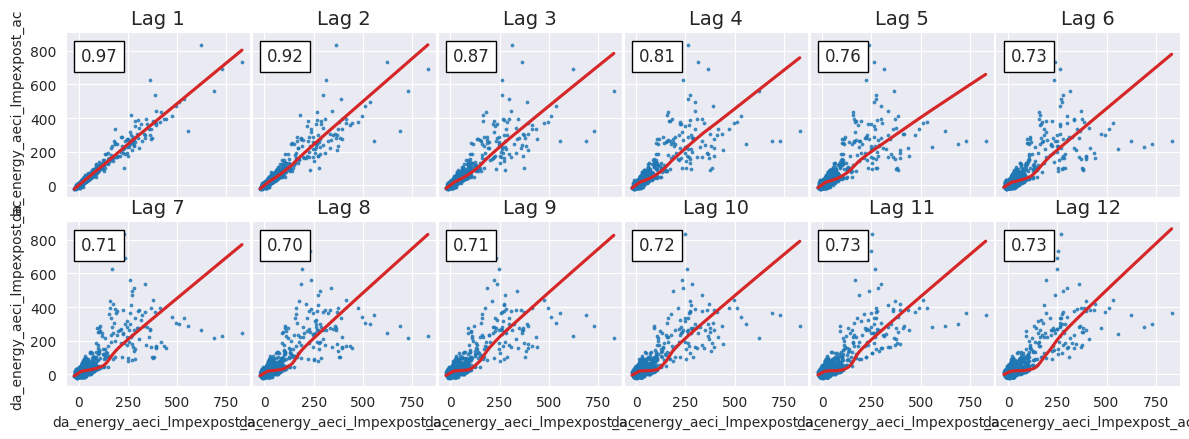

In [75]:
plot_lags(df[target], lags=12, nrows=2)


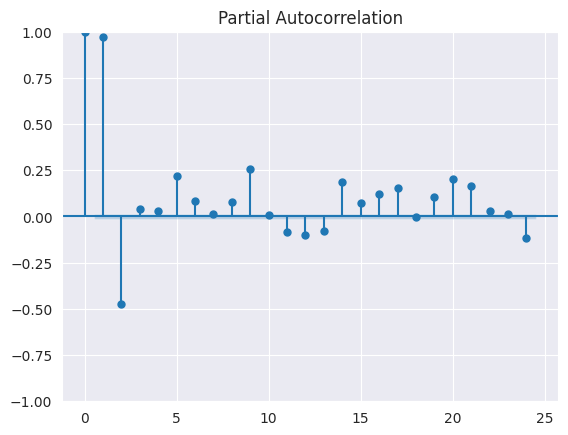

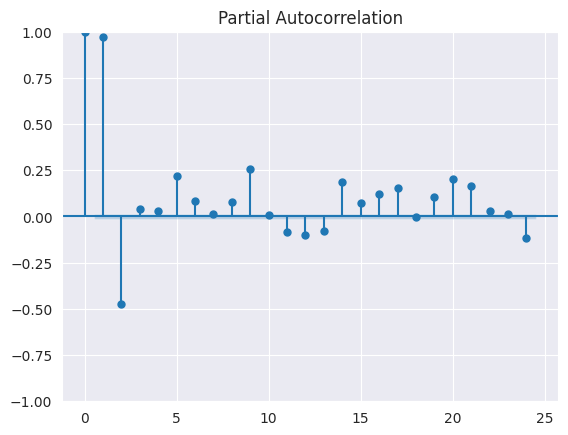

In [76]:
plot_pacf(df[target], lags=24)

In [77]:
lags = [1, 2, 5, 9]

def make_lag(Xy, lags, target):
    Xy = Xy.copy()
    for lag in lags:
        Xy[f"{target}_lag_{lag}"] = Xy[target].shift(lag)
    return Xy.dropna()

Xy = make_lag(Xy, lags, target)

X_original = Xy.drop(target, axis=1)
y = Xy[target]

# split train and test
n_train = int(0.85*len(X_original))
n_test = len(X_original) - n_train
X_original_train = X_original[:n_train]
y_train = y[:n_train]
X_original_test = X_original[n_train:]
y_test = y[n_train:]

# add deterministic features
fourier = CalendarFourier(freq="W", order=12)  # 10 sin/cos pairs for Weekly seasonality
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=0,                     # trend (order 1 means linear)
    seasonal=True,               # daily seasonality (indicators)
    additional_terms=[fourier],         # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)
X_dp_train = dp.in_sample()  # create features for dates in tunnel.index

# concatenate original features with deterministic features
X_train = pd.concat([X_original_train, X_dp_train], axis=1)
X_test = pd.concat([X_original_test, dp.out_of_sample(steps=n_test)], axis=1)

In [78]:
X_train.columns

Index(['central_mtlf_fc', 'north_mtlf_fc', 'south_mtlf_fc', 'system_mtlf_fc',
       'ia_ksux_ws_mph_fc', 'il_kmdw_ws_mph_fc', 'il_kord_ws_mph_fc',
       'mi_kanj_ws_mph_fc', 'mi_karb_ws_mph_fc', 'mi_kazo_ws_mph_fc',
       'mi_klan_ws_mph_fc', 'mn_kinl_ws_mph_fc', 'mn_krst_ws_mph_fc',
       'mo_kstl_ws_mph_fc', 'oh_kakr_ws_mph_fc', 'ok_kclk_ws_mph_fc',
       'ok_kokc_ws_mph_fc', 'ok_ktul_ws_mph_fc', 'ok_kwdg_ws_mph_fc',
       'sc_kchs_ws_mph_fc', 'ar_kjbr_td_f_fc', 'ia_kdsm_td_f_fc',
       'ia_ksux_td_f_fc', 'in_kfwa_td_f_fc', 'in_kind_td_f_fc',
       'in_klaf_td_f_fc', 'in_ksbn_td_f_fc', 'ky_ksdf_td_f_fc',
       'la_kbtr_td_f_fc', 'la_klch_td_f_fc', 'la_kshv_td_f_fc',
       'mi_klan_td_f_fc', 'mn_kinl_td_f_fc', 'mn_kpqn_td_f_fc',
       'mo_ksgf_td_f_fc', 'mo_kstl_td_f_fc', 'oh_kluk_td_f_fc',
       'ok_klaw_td_f_fc', 'da_energy_aeci_lmpexpost_ac_lag_1',
       'da_energy_aeci_lmpexpost_ac_lag_2',
       'da_energy_aeci_lmpexpost_ac_lag_5',
       'da_energy_aeci_lmpexpost_ac

/home/yyf/miniconda3/envs/tts-tf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+05, tolerance: 1.726e+03
  model = cd_fast.enet_coordinate_descent(


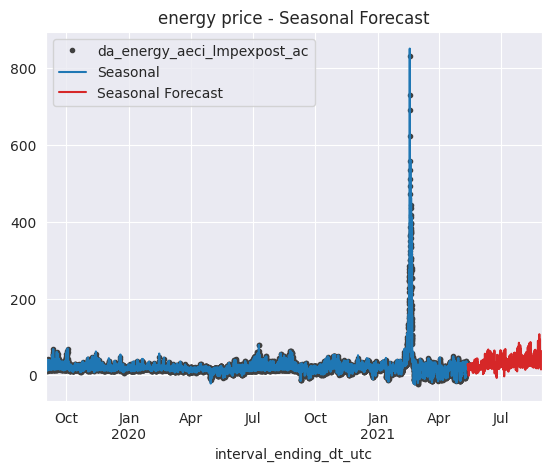

In [79]:
# run 
model = Lasso(fit_intercept=False, alpha=0.1)
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_train.plot(color='0.25', style='.', title="energy price - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

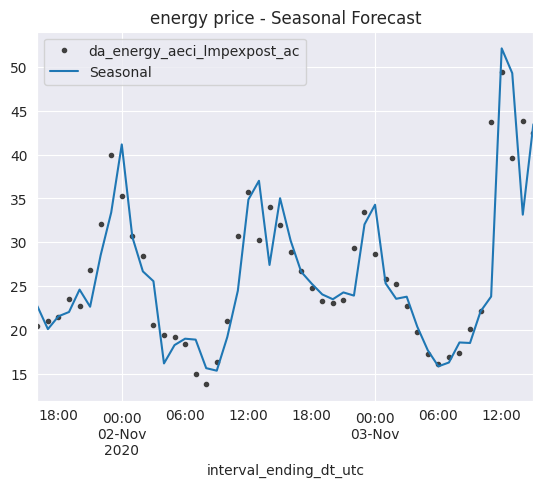

In [80]:
ax = y_train[-24*192:-24*190].plot(color='0.25', style='.', title="energy price - Seasonal Forecast")
ax = y_pred[-24*192:-24*190].plot(ax=ax, label="Seasonal")
#ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [81]:
mae_train = mean_absolute_error(y_train, y_pred)
mse_train = mean_squared_error(y_train, y_pred)
r2_train = r2_score(y_train, y_pred)

mae_test = mean_absolute_error(y_test, y_fore)
mse_test = mean_squared_error(y_test, y_fore)
r2_test = r2_score(y_test, y_fore)

print('training metrics: mae: {}, mse: {}, r2: {}'.format(mae_train, mse_train, r2_train))
print('testing metrics: mae: {}, mse: {}, r2: {}'.format(mae_test, mse_test, r2_test))

training metrics: mae: 1.8091759884762426, mse: 26.175456195885612, r2: 0.9640664893468988
testing metrics: mae: 2.537567260434031, mse: 12.010111694414363, r2: 0.9430921135670587


Now we see the linear model is better than the baseline model.
But the prediction is still one-step delayed as in the baseline model. This is a common problem in time series analysis with delayed features.
We need find a feature that can reflect the sudden change of the target.


In [ ]:
X_train.to_csv('./data/X_train.csv')
y_train.to_csv('./data/y_train.csv')
X_test.to_csv('./data/X_test.csv')
y_test.to_csv('./data/y_test.csv')